# Workflow

### Importación de librerías

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import workflow as wf

Using TensorFlow backend.


#### Recarga del script en el noteook si se realizan cambios

In [3]:
import importlib
importlib.reload(wf)

<module 'workflow' from '/home/fernando/Documents/AAA-Workflow/workflow.py'>

### Carga y preprocesamiento de los datos

#### Path a los datos y variable obetivo

In [4]:
path = "REGISTRO  FERNANDO PARA IA.xls"
target = "EXITUS30D"

#### Carga de los datos y estandarización de los mismos:
- missing values: [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a']
- bools: ['Sí', 'sí', 'SI', 'Si'] -> 'si', lo mismo para 'No'
- lower

In [5]:
datos_raw = wf.load_and_clean(path)

(372, 104)


#### Eliminación de aquellas columnas no relevantes para el estudio

In [6]:
datos_raw = wf.drop_initials_columns(datos_raw)

In [7]:
datos_raw.shape

(372, 77)

In [8]:
datos_raw

,EDAD,SEXO,TABAQUISMO,HTA,DL,CISQ,EPOC,ICTUS,TTOMED_cat,Otro_tto,...,FA,PARAPLEGIA,EXITUS30D,CAUSAMUERTEA30D,OTRACOMPLI_MAYOR,CTCONTROL30D,LEAKCTCONTROL,TIPOLEAKCONTROL,OTRACOMPOST,OTRACOMPLICPOSTEVAR
0,84.0,varón,no fuma,si,no,si,si,no,anticoagulado,NaN,...,no,no,no,NaN,NaN,si,NaN,NaN,no,no
1,62.0,varón,fumador activo,si,si,no,no,no,no,NaN,...,no,no,no,NaN,NaN,no,NaN,NaN,no,no
2,65.0,mujer,no fuma,no,no,no,no,no,no,NaN,...,no,no,no,NaN,NaN,si,si,ii,no,no
3,81.0,varón,fumador activo,si,si,si,no,no,no,NaN,...,no,no,no,NaN,NaN,si,si,ii,no,no
4,82.0,varón,fumador activo,si,si,si,si,no,no,NaN,...,no,no,no,NaN,NaN,no,NaN,NaN,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,73.0,varón,fumador activo,si,si,no,si,no,antiagregado,NaN,...,no,NaN,no,digestiva,NaN,si,no,NaN,si,infeccion evar
368,81.0,varón,exfumador desde hace más de 6 meses,si,si,no,si,no,anticoagulado,NaN,...,no,NaN,no,NaN,NaN,si,no,NaN,no,no
369,79.0,varón,fumador activo,si,si,no,no,si,antiagregado,NaN,...,no,NaN,no,NaN,NaN,si,no,NaN,NaN,NaN
370,88.0,varón,fumador activo,si,si,no,no,no,antiagregado,NaN,...,no,NaN,no,NaN,NaN,si,no,NaN,NaN,NaN


#### Codificación de los datos, tres técnicas disponibles:
- Para utilizar técnicas de muestreo:
  - ordinal encoding - `wf.ordinal_encoding()`
- Para entrenar directamente los modelos neuronales
  - binary enconding - `wf.binary_encoding()`
  - one hot encoding - `wf.one_hot_encoding()`

In [10]:
datos_raw.EXITUS30D.unique()

array(['no', 'si', nan], dtype=object)

In [11]:
#  hash_encoding
data_encoded = wf.ordinal_encoding(datos_raw)

In [12]:
data_encoded

,EDAD,SEXO,TABAQUISMO,HTA,DL,CISQ,EPOC,ICTUS,TTOMED_cat,Otro_tto,...,FA,PARAPLEGIA,EXITUS30D,CAUSAMUERTEA30D,OTRACOMPLI_MAYOR,CTCONTROL30D,LEAKCTCONTROL,TIPOLEAKCONTROL,OTRACOMPOST,OTRACOMPLICPOSTEVAR
0,31.0,2.0,3.0,1.0,0.0,2.0,1.0,1.0,2.0,NaN,...,1.0,1.0,1.0,NaN,NaN,3.0,NaN,NaN,1.0,16.0
1,9.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,4.0,NaN,...,1.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN,1.0,16.0
2,12.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,4.0,NaN,...,1.0,1.0,1.0,NaN,NaN,3.0,2.0,1.0,1.0,16.0
3,28.0,2.0,2.0,1.0,1.0,2.0,0.0,1.0,4.0,NaN,...,1.0,1.0,1.0,NaN,NaN,3.0,2.0,1.0,1.0,16.0
4,29.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,4.0,NaN,...,1.0,1.0,1.0,NaN,NaN,2.0,NaN,NaN,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,20.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,...,1.0,NaN,1.0,1.0,NaN,3.0,1.0,NaN,2.0,10.0
368,28.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,NaN,...,1.0,NaN,1.0,NaN,NaN,3.0,1.0,NaN,1.0,16.0
369,26.0,2.0,2.0,1.0,1.0,1.0,0.0,2.0,0.0,NaN,...,1.0,NaN,1.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN
370,35.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,...,1.0,NaN,1.0,NaN,NaN,3.0,1.0,NaN,NaN,NaN


In [12]:
# # join column col_0, col_1, ..., col_7 into a new column of vector
# data_encoded["EXITUS30D"] = data_encoded.iloc[:, 0:8].apply(lambda x: ''.join(x.astype(str)), axis=1)
# # drop
# data_encoded = data_encoded.drop(columns=data_encoded.columns[0:8])

In [13]:
# data_encoded["EXITUS30D"] to int
# data_encoded["EXITUS30D"] = data_encoded["EXITUS30D"].astype(int)

In [14]:
# data_encoded.EXITUS30D

#### Estudio de correlación de los datos:
- Test de Kruskal-Wallis para conjuntos de datos numéricos y categóricos - `wf.kruskal_wallis_test()` (Si Plot=True, mostramos en el output el p-valor de cada variable)
- Test Chi-cuadrado para conjuntos de datos categóricos - `wf.chi_squared_test()`

In [13]:
datos_kruskal = wf.kruskal_wallis_test(data_encoded, target, plot=False)

In [14]:
datos_kruskal.shape

(372, 66)

#### Test para la selección de porcentae máximo de missing values y técnica de imputación de los mismos:
- Porcentajes de missing values a probar: 5%, 10%, 15%, 20%, 40% y 60%
- Técnicas de imputación aplicadas:
  - Media
  - Moda
  - K Nearest Neighbors
  - Random Forest
- Cálculo de MSE para validar cada una de las combinaciones posibles

In [ ]:
# wf.imputation_tests(datos_kruskal, target)

#### Eliminación de missing values en función del porcentaje máximo permitido seleccionado

In [15]:
data_dropped = wf.drop_missing_values_columns(datos_kruskal, 8)

Columnas dropeadas:  ['Otro_tto', 'LONGCUELLOMM', 'ANGULCUELLOAPGRADOS', 'ANGULCUELLOLATGRADOS', 'DIAMCUELLORENAL1', 'DIAMCUELLORENAL2', 'TIPOLEAK', 'RELINING', 'Otros_tec_rec', 'IBE', 'FENESTRADA', 'CUFF_PROXIMAL', 'APTUS', 'LEUCOCITOS48POST', 'PARAPLEGIA', 'CAUSAMUERTEA30D', 'LEAKCTCONTROL', 'TIPOLEAKCONTROL', 'OTRACOMPOST', 'OTRACOMPLICPOSTEVAR']
Numero de columnas dropeadas:  20
Numero de columnas tras aplicar el porcentaje:  46


In [16]:
# get elements that are different between datos_kruskal.columns and data_dropped.columns
print(set(datos_kruskal.columns) - set(data_dropped.columns))
print(len(set(datos_kruskal.columns) - set(data_dropped.columns)))

{'Otro_tto', 'Otros_tec_rec', 'ANGULCUELLOLATGRADOS', 'DIAMCUELLORENAL1', 'DIAMCUELLORENAL2', 'LONGCUELLOMM', 'ANGULCUELLOAPGRADOS', 'CAUSAMUERTEA30D', 'OTRACOMPLICPOSTEVAR', 'IBE', 'APTUS', 'RELINING', 'LEAKCTCONTROL', 'TIPOLEAK', 'FENESTRADA', 'LEUCOCITOS48POST', 'PARAPLEGIA', 'CUFF_PROXIMAL', 'TIPOLEAKCONTROL', 'OTRACOMPOST'}
20


In [17]:
data_dropped.shape

(372, 46)

#### Imputación de los missing values restantes aplicando la técnica con mejores resultados del test
- Opciones:
    - `wf.mode_imputation()`
    - `wf.mean_imputation()`
    - `wf.knn_imputation()`
    - `wf.random_forest_imputation()`

In [18]:
# datos_mode = wf.mode_imputation(datos_kruskal, target)
datos_mode = wf.mode_imputation(data_dropped, target)

#### Guardado de los datos limpios, codificados y sin ningún missing value

In [19]:
datos_mode.to_excel('datasets_generados/datos_codificados_y_rellenados.xlsx')

#### Normalización o Estandarización de los datos a una misma escala
- Opciones posibles:
    - MinMax normalization (`wf.min_max_normalization()`)
    - Standard Scaler (`wf.standar_scaler()`)

In [20]:
data_normalize = wf.min_max_normalization(datos_mode)

#### Guardado de los datos normalizados o estandarizados (cambiar nombre)

In [21]:
data_normalize.to_excel('datasets_generados/datos_normalizados.xlsx')

In [22]:
data_normalize

,EDAD,SEXO,TABAQUISMO,HTA,DL,CISQ,EPOC,CIRREVASCPREVIA,EVARURGPROG,CLINICAASINTSINTOM,...,ACV,DIGESTIVA,TRASFUSION,RESPIRATORIA,RENAL,ICC,IAM,FA,EXITUS30D,CTCONTROL30D
0,0.815789,1.0,1.000000,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000
1,0.236842,1.0,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
2,0.315789,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
3,0.736842,1.0,0.666667,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
4,0.763158,1.0,0.666667,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,0.526316,1.0,0.666667,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000
368,0.736842,1.0,0.333333,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
369,0.684211,1.0,0.666667,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000
370,0.921053,1.0,0.666667,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000


#### Creación de los conjuntos de test con datos originales, antes de aplicar el muestreo

In [23]:
x_test_original = data_normalize[data_normalize[target]==1]
x_test_original = x_test_original.append(data_normalize[data_normalize[target]==0])
x_test_original = x_test_original.iloc[0:58]
y_test_original = x_test_original[target]
x_test_original = x_test_original.drop(columns=[target])

### Original data

#### Preparación de los datos y creación de conjuntos de train y test de cara al entrenamiento de los modelos

In [24]:
data_normalize_dropped = data_normalize.drop(columns = [target])

In [25]:
x_train, x_test, y_train, y_test, network_output = wf.prep_datos_red(target , data_normalize, data_normalize_dropped)

(297, 45) (75, 45)
(297, 1) (75, 1)


#### Grid Search para la búsqueda de los mejores parámetros:
- Para establecer o modificar estos ir a `def grid_search_mlp()` en `workflow.py`

In [ ]:
# best_params = wf.grid_search_mlp(x_train, y_train, x_test, y_test)

#### Parámetros seleccionados manualmente para saltar el proceso del Grid Search en reiteradas ocasiones,  saltar a la línea siguiente al ejecutar para seleccionar los mejores

In [26]:
best_params = {'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'neurons': 12}

In [27]:
best_params

{'batch_size': 16, 'dropout_rate': 0.2, 'epochs': 50, 'neurons': 12}

##### Compatibilidad de los modelos tanto con TensorFlow 1.0 como con 2.0

In [28]:
wf.tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


##### Limpiamos todos aquellos modelos que se han quedado guardados en memoria

In [29]:
wf.tf.keras.backend.clear_session()

#### Entrenamiento de múltiples MLPs y guardado de los mismos
- n = 10 es el número de modelos a entrenar
- patience = 5 es el parámetro para `wf.tf.keras.callbacks.EarlyStopping`

In [30]:
wf.train_multiple_models(x_train, y_train, x_test_original, y_test_original, 10, best_params, 'models/normal/model_', 5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2022-06-03 10:15:36.855593: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-06-03 10:15:36.877535: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2499950000 Hz
2022-06-03 10:15:36.879625: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55b35cdaf330 executing computations on platform Host. Devices:
2022-06-03 10:15:36.879756: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]
Media:  0.5


#### Carga de los modelos desde el path donde están almacenados y realización de la media entre las capas de los modelos

In [31]:
best_model = wf.load_and_ensemble_best_model(10, 'models/normal/model_', plot=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
>loaded models/normal/model_0.h5
>loaded models/normal/model_1.h5
>loaded models/normal/model_2.h5
>loaded models/normal/model_3.h5
>loaded models/normal/model_4.h5
>loaded models/normal/model_5.h5
>loaded models/normal/model_6.h5
>loaded models/normal/model_7.h5
>loaded models/normal/model_8.h5
>loaded models/normal/model_9.h5


#### Entrenamiento del mejor modelo sobre el conjunto de train generado anteriormente

Train on 237 samples, validate on 60 samples
Epoch 1/50
237/237 - 1s - loss: 0.6340 - acc: 0.9198 - val_loss: 0.6029 - val_acc: 0.9333
Epoch 2/50
237/237 - 0s - loss: 0.5794 - acc: 0.9198 - val_loss: 0.5340 - val_acc: 0.9333
Epoch 3/50
237/237 - 0s - loss: 0.4994 - acc: 0.9198 - val_loss: 0.4368 - val_acc: 0.9333
Epoch 4/50
237/237 - 0s - loss: 0.4109 - acc: 0.9198 - val_loss: 0.3331 - val_acc: 0.9333
Epoch 5/50
237/237 - 0s - loss: 0.3327 - acc: 0.9198 - val_loss: 0.2637 - val_acc: 0.9333
Epoch 6/50
237/237 - 0s - loss: 0.3245 - acc: 0.9198 - val_loss: 0.2394 - val_acc: 0.9333
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                804       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________

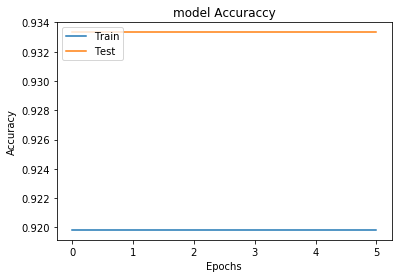

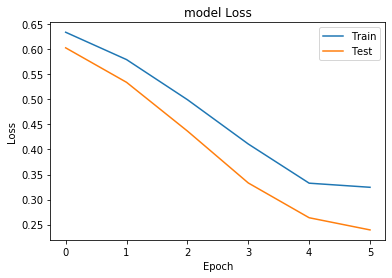

In [28]:
best_model_train = wf.train_model(best_model, best_params, x_train, y_train, patience=5)

#### Predicción sobre el conjunto de datos originales:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)

Classification Report

              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67        29
         1.0       0.00      0.00      0.00        29

    accuracy                           0.50        58
   macro avg       0.25      0.50      0.33        58
weighted avg       0.25      0.50      0.33        58



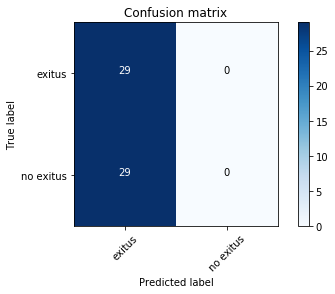

Accuracy: 0.5
Specificity: 1.0
Sensitivity: 0.0
Precision: nan
AUC: 0.5


In [32]:
predicts = wf.predict_model_and_report(best_model, x_test_original, y_test_original, ['exitus', 'no exitus'])

### SMOTE + Tomed Links data

#### Aplicación de la técnicas de muestro para desbalancear los datos

In [28]:
data_balanced = wf.smote_tomed_link(data_normalize, target)

In [29]:
data_balanced[target].value_counts()

1.0    343
0.0    343
Name: EXITUS30D, dtype: int64

In [30]:
data_balanced.to_excel('datasets_generados/datos_balanceados_smote_tomed_links.xlsx')

#### Preparación de los datos y creación de conjuntos de train y test de cara al entrenamiento de los modelos

In [31]:
data_balanced_dropped = data_balanced.drop(columns = [target])

In [32]:
x_train, x_test, y_train, y_test, network_output = wf.prep_datos_red(target , data_balanced, data_balanced_dropped)

(548, 45) (138, 45)
(548, 1) (138, 1)


#### Grid Search para la búsqueda de los mejores parámetros:
- Para establecer o modificar estos ir a `def grid_search_mlp()` en `workflow.py`

In [ ]:
# best_params = wf.grid_search_mlp(x_train, y_train, x_test_original, y_test_original)

#### Parámetros seleccionados manualmente para saltar el proceso del Grid Search en reiteradas ocasiones,  saltar a la línea siguiente al ejecutar para seleccionar los mejores

In [34]:
best_params = {'batch_size': 16, 'dropout_rate': 0.15, 'epochs': 15, 'neurons': 16}

In [35]:
best_params

{'batch_size': 16, 'dropout_rate': 0.15, 'epochs': 15, 'neurons': 16}

##### Compatibilidad de los modelos tanto con TensorFlow 1.0 como con 2.0

In [36]:
wf.tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


##### Limpiamos todos aquellos modelos que se han quedado guardados en memoria

In [37]:
wf.tf.keras.backend.clear_session()

#### Entrenamiento de múltiples MLPs y guardado de los mismos
- n = 10 es el número de modelos a entrenar
- patience = 5 es el parámetro para `wf.tf.keras.callbacks.EarlyStopping`

In [51]:
wf.train_multiple_models(x_train, y_train, x_test_original, y_test_original, 10, best_params, 'models/normal/model_', 3)

[0.9137931034482759, 0.8793103448275862, 0.8275862068965517, 0.7586206896551724, 0.7758620689655172, 0.8620689655172413, 0.7931034482758621, 0.8793103448275862, 0.896551724137931, 0.8275862068965517]
Media:  0.8413793103448276


#### Carga de los modelos desde el path donde están almacenados y realización de la media entre las capas de los modelos

In [52]:
best_model = wf.load_and_ensemble_best_model(10, 'models/normal/model_', plot=True)

>loaded models/normal/model_0.h5
>loaded models/normal/model_1.h5
>loaded models/normal/model_2.h5
>loaded models/normal/model_3.h5
>loaded models/normal/model_4.h5
>loaded models/normal/model_5.h5
>loaded models/normal/model_6.h5
>loaded models/normal/model_7.h5
>loaded models/normal/model_8.h5
>loaded models/normal/model_9.h5


#### Entrenamiento del mejor modelo sobre el conjunto de train generado anteriormente

Train on 438 samples, validate on 110 samples
Epoch 1/15
438/438 - 1s - loss: 0.6771 - acc: 0.7215 - val_loss: 0.6668 - val_acc: 0.8091
Epoch 2/15
438/438 - 0s - loss: 0.6446 - acc: 0.8425 - val_loss: 0.6267 - val_acc: 0.7727
Epoch 3/15
438/438 - 0s - loss: 0.5878 - acc: 0.8379 - val_loss: 0.5538 - val_acc: 0.8273
Epoch 4/15
438/438 - 0s - loss: 0.4969 - acc: 0.8630 - val_loss: 0.4709 - val_acc: 0.8455
Epoch 5/15
438/438 - 0s - loss: 0.4129 - acc: 0.8767 - val_loss: 0.4036 - val_acc: 0.8455
Epoch 6/15
438/438 - 0s - loss: 0.3478 - acc: 0.8881 - val_loss: 0.3578 - val_acc: 0.8455
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                736       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
________________________________________________________________

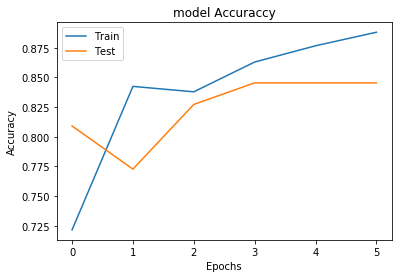

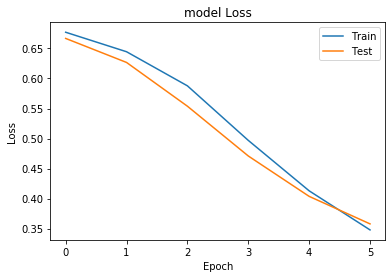

In [53]:
best_model_train = wf.train_model(best_model, best_params, x_train, y_train, patience=2)

#### Predicción sobre el conjunto de datos originales:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)

Classification Report

              precision    recall  f1-score   support

         0.0       0.82      0.79      0.81        29
         1.0       0.80      0.83      0.81        29

    accuracy                           0.81        58
   macro avg       0.81      0.81      0.81        58
weighted avg       0.81      0.81      0.81        58



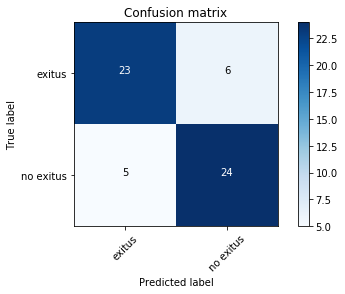

Accuracy: 0.8103
Specificity: 0.7931
Sensitivity: 0.8276
Precision: 0.8
AUC: 0.8103


In [54]:
predicts = wf.predict_model_and_report(best_model, x_test_original, y_test_original, ['exitus', 'no exitus'])

### SMOTE + ENN data

#### Aplicación de la técnicas de muestro para desbalancear los datos

In [153]:
data_balanced = wf.smote_edited_nearest_neighbor(data_normalize, target)

In [154]:
data_balanced.to_excel('datasets_generados/datos_balanceados_smote_enn.xlsx')

In [155]:
data_balanced[target].value_counts()

1.0    343
0.0    301
Name: EXITUS30D, dtype: int64

#### Preparación de los datos y creación de conjuntos de train y test de cara al entrenamiento de los modelos

In [55]:
data_balanced_dropped = data_balanced.drop(columns = [target])

In [56]:
x_train, x_test, y_train, y_test, network_output = wf.prep_datos_red(target , data_balanced, data_balanced_dropped)

(548, 45) (138, 45)
(548, 1) (138, 1)


#### Grid Search para la búsqueda de los mejores parámetros:
- Para establecer o modificar estos ir a `def grid_search_mlp()` en `workflow.py`

In [ ]:
best_params = wf.grid_search_mlp(x_train, y_train, x_test, y_test)

#### Parámetros seleccionados manualmente para saltar el proceso del Grid Search en reiteradas ocasiones,  saltar a la línea siguiente al ejecutar para seleccionar los mejores

In [58]:
best_params = {'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'neurons': 12}

In [59]:
image.pngbest_params

{'batch_size': 16, 'dropout_rate': 0.3, 'epochs': 50, 'neurons': 12}

##### Compatibilidad de los modelos tanto con TensorFlow 1.0 como con 2.0

In [60]:
wf.tf.compat.v1.disable_v2_behavior()

##### Limpiamos todos aquellos modelos que se han quedado guardados en memoria

In [61]:
wf.tf.keras.backend.clear_session()

#### Entrenamiento de múltiples MLPs y guardado de los mismos
- n = 10 es el número de modelos a entrenar
- patience = 5 es el parámetro para `wf.tf.keras.callbacks.EarlyStopping`

In [74]:
wf.train_multiple_models(x_train, y_train, x_test_original, y_test_original, 10, best_params, 'models/normal/model_', 5)

[0.9482758620689655, 0.8793103448275862, 0.8103448275862069, 0.9310344827586207, 0.9655172413793104, 0.9310344827586207, 0.8793103448275862, 0.9482758620689655, 0.896551724137931, 0.8448275862068966]
Media:  0.9034482758620689


#### Carga de los modelos desde el path donde están almacenados y realización de la media entre las capas de los modelos

In [75]:
best_model = wf.load_and_ensemble_best_model(10, 'models/normal/model_', plot=True)

>loaded models/normal/model_0.h5
>loaded models/normal/model_1.h5
>loaded models/normal/model_2.h5
>loaded models/normal/model_3.h5
>loaded models/normal/model_4.h5
>loaded models/normal/model_5.h5
>loaded models/normal/model_6.h5
>loaded models/normal/model_7.h5
>loaded models/normal/model_8.h5
>loaded models/normal/model_9.h5


#### Entrenamiento del mejor modelo sobre el conjunto de train generado anteriormente

Train on 438 samples, validate on 110 samples
Epoch 1/50
438/438 - 1s - loss: 0.6694 - acc: 0.7466 - val_loss: 0.6456 - val_acc: 0.8727
Epoch 2/50
438/438 - 0s - loss: 0.6204 - acc: 0.8311 - val_loss: 0.5947 - val_acc: 0.8545
Epoch 3/50
438/438 - 0s - loss: 0.5656 - acc: 0.8288 - val_loss: 0.5315 - val_acc: 0.8364
Epoch 4/50
438/438 - 0s - loss: 0.4963 - acc: 0.8630 - val_loss: 0.4701 - val_acc: 0.8364
Epoch 5/50
438/438 - 0s - loss: 0.4391 - acc: 0.8607 - val_loss: 0.4173 - val_acc: 0.8455
Epoch 6/50
438/438 - 0s - loss: 0.3861 - acc: 0.8721 - val_loss: 0.3839 - val_acc: 0.8455
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                552       
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
________________________________________________________________

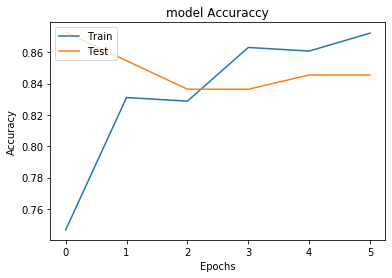

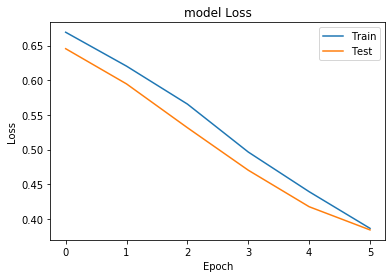

In [76]:
best_model_train = wf.train_model(best_model, best_params, x_train, y_train, patience=5)

#### Predicción sobre el conjunto de datos originales:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)

Classification Report

              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82        29
         1.0       0.81      0.86      0.83        29

    accuracy                           0.83        58
   macro avg       0.83      0.83      0.83        58
weighted avg       0.83      0.83      0.83        58



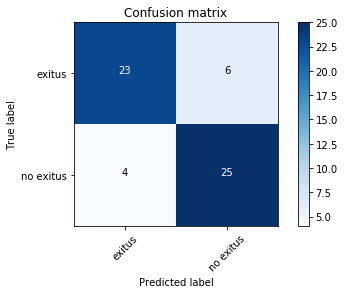

Accuracy: 0.8276
Specificity: 0.7931
Sensitivity: 0.8621
Precision: 0.8065
AUC: 0.8276


In [77]:
predicts = wf.predict_model_and_report(best_model_train, x_test_original, y_test_original, ['exitus', 'no exitus'])

### Shap Deep Explainer

In [77]:
deep_explainer, deep_values, x_train_deep_df = wf.shap_deep_explainer(data_balanced_dropped, x_train, x_test_original, best_model_train)

#### Force Plot que representa los valores de Shappley para cada atributo a lo largo de todas las predicciones

In [79]:
import shap

In [80]:
shap.force_plot(deep_explainer.expected_value, deep_values[0], x_train_deep_df, link="logit")

#### Plot con el sumatorio de los valores de Shappley para cada atributo, obteniendo como resultado las características más importantes en las decisiones de los modelos

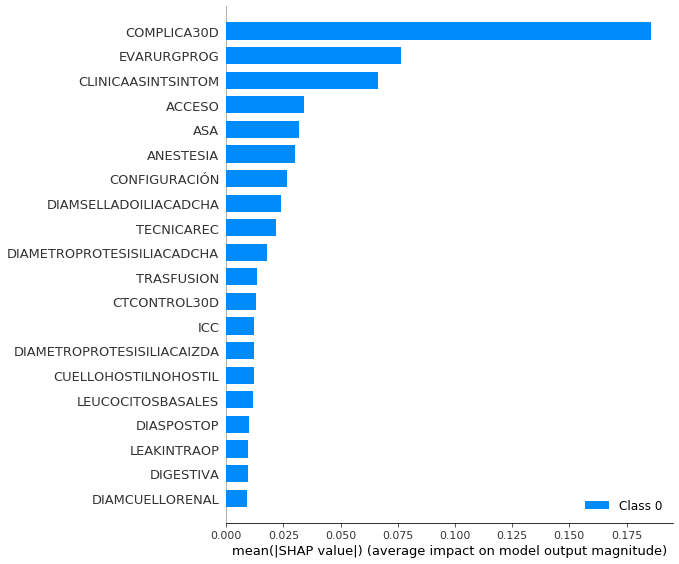

In [81]:
wf.shap_summary_plot(deep_values, x_train_deep_df)

##### Creación de los conjuntos de datos(train) a partir de este subconjunto de características

In [82]:
deep_features, deep_features_drop, features = wf.features_df(data_balanced, deep_values, 8, target)

#### Conjuntos de test tras la reducción de las características o variables menos influyentes

In [83]:
x_test_original_df = x_test_original[features]
y_test_original_df = y_test_original

#### Preparación de los datos y creación de conjuntos de train y test de cara al entrenamiento de los modelos

In [84]:
x_train_df, x_test_df, y_train_df, y_test_df, network_output_df = wf.prep_datos_red(target, deep_features, deep_features_drop)

(516, 8) (130, 8)
(516, 1) (130, 1)


##### Limpiamos todos aquellos modelos que se han quedado guardados en memoria

In [86]:
import tensorflow as tf

tf.keras.backend.clear_session()

#### Entrenamiento de múltiples MLPs y guardado de los mismos
- n = 10 es el número de modelos a entrenar
- patience = 5 es el parámetro para `wf.tf.keras.callbacks.EarlyStopping`

In [87]:
wf.train_multiple_models(x_train_df, y_train_df, x_test_original_df, y_test_original_df, 10, best_params, 'models/features/model_', 5)

[0.9482758620689655, 0.9655172413793104, 0.8448275862068966, 0.7931034482758621, 0.8620689655172413, 0.9137931034482759, 0.9482758620689655, 0.9655172413793104, 0.8448275862068966, 0.8448275862068966]
Media:  0.8931034482758621


#### Carga de los modelos desde el path donde están almacenados y realización de la media entre las capas de los modelos

In [88]:
best_model = wf.load_and_ensemble_best_model(10, 'models/features/model_', plot=True)

>loaded models/features/model_0.h5
>loaded models/features/model_1.h5
>loaded models/features/model_2.h5
>loaded models/features/model_3.h5
>loaded models/features/model_4.h5
>loaded models/features/model_5.h5
>loaded models/features/model_6.h5
>loaded models/features/model_7.h5
>loaded models/features/model_8.h5
>loaded models/features/model_9.h5


#### Entrenamiento del mejor modelo sobre el conjunto de train generado anteriormente

Train on 412 samples, validate on 104 samples
Epoch 1/50
412/412 - 1s - loss: 0.6526 - acc: 0.8204 - val_loss: 0.6357 - val_acc: 0.9423
Epoch 2/50
412/412 - 0s - loss: 0.6131 - acc: 0.8908 - val_loss: 0.5909 - val_acc: 0.9423
Epoch 3/50
412/412 - 0s - loss: 0.5581 - acc: 0.8981 - val_loss: 0.5255 - val_acc: 0.9519
Epoch 4/50
412/412 - 0s - loss: 0.4816 - acc: 0.9102 - val_loss: 0.4460 - val_acc: 0.9423
Epoch 5/50
412/412 - 0s - loss: 0.4109 - acc: 0.9248 - val_loss: 0.3639 - val_acc: 0.9423
Epoch 6/50
412/412 - 0s - loss: 0.3417 - acc: 0.9345 - val_loss: 0.2955 - val_acc: 0.9423
Epoch 7/50
412/412 - 0s - loss: 0.2948 - acc: 0.9126 - val_loss: 0.2447 - val_acc: 0.9519
Epoch 8/50
412/412 - 0s - loss: 0.2637 - acc: 0.9175 - val_loss: 0.2096 - val_acc: 0.9615
Epoch 9/50
412/412 - 0s - loss: 0.2153 - acc: 0.9490 - val_loss: 0.1841 - val_acc: 0.9615
Epoch 10/50
412/412 - 0s - loss: 0.2096 - acc: 0.9490 - val_loss: 0.1677 - val_acc: 0.9615
Epoch 11/50
412/412 - 0s - loss: 0.1867 - acc: 0.9345

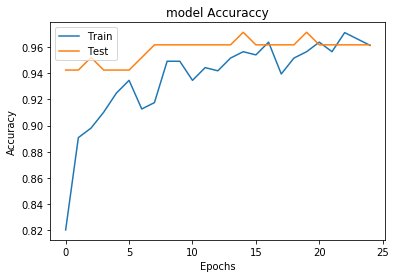

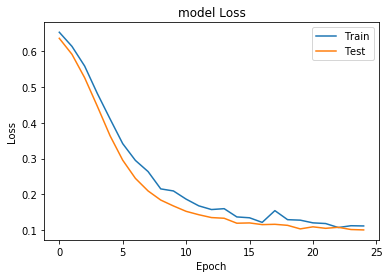

In [89]:
best_model_train_df = wf.train_model(best_model, best_params, x_train_df, y_train_df, patience=10)

#### Predicción sobre el conjunto de datos originales:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)

Classification Report

              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95        29
         1.0       0.93      0.97      0.95        29

    accuracy                           0.95        58
   macro avg       0.95      0.95      0.95        58
weighted avg       0.95      0.95      0.95        58



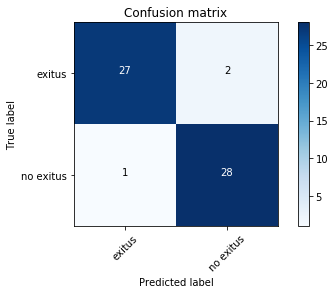

Accuracy: 0.9483
Specificity: 0.931
Sensitivity: 0.9655
Precision: 0.9333
AUC: 0.9483


In [90]:
predicts_df = wf.predict_model_and_report(best_model_train_df, x_test_original_df, y_test_original_df, ['exitus', 'no exitus'])

#### Guardamos las predicciones realizadas por el modelo para usarlas posteriormente en los Árboles de Decisión

Classification Report

              precision    recall  f1-score   support

           0       1.00      0.95      0.97       242
           1       0.96      1.00      0.98       274

    accuracy                           0.98       516
   macro avg       0.98      0.98      0.98       516
weighted avg       0.98      0.98      0.98       516



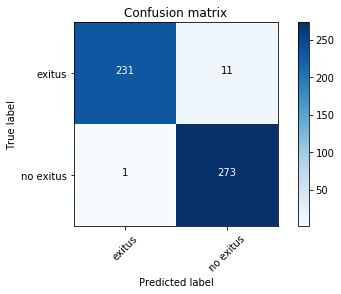

Accuracy: 0.9767
Specificity: 0.9545
Sensitivity: 0.9964
Precision: 0.9613
AUC: 0.9754


In [91]:
predicts_deep = wf.predict_model_and_report(best_model_train_df, x_train_df, y_train_df, ['exitus', 'no exitus'])

### BASELINE NO NEURONALES

#### Sobre los datos tras aplicar la reducción de características:
- K Nearest Neigghbors
- Support Vector Machine
- Logistic Regression

In [ ]:
wf.knn_classifier(x_train_df, y_train_df, x_test_original_df, y_test_original_df)

In [ ]:
wf.svm_classifier(x_train_df, y_train_df, x_test_original_df, y_test_original_df)

In [ ]:
wf.lr_classifier(x_train_df, y_train_df, x_test_original_df, y_test_original_df)

### Árboles de Decisión

#### CART: Implementación tradicional, entrenando el modelo jerárquico directamente sobre los datos

##### Extraemos lo siguiente:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)
- Conjunto de reglas

In [ ]:
cart_tree, cart_tree_rules, features = wf.cart_decision_tree(deep_features_drop, x_train_df, predicts_deep, x_test_original_df, y_test_original_df, 'entropy')

##### Generación del plot con el árbol de decisión resultante

In [ ]:
dt_graph = wf.plot_tree(cart_tree, features)
Image(dt_graph.create_png())

#### TREPAN: Modelo jerárquico que utilizado el modelo neuronal y sus predicciones como complemento en el proceso de entrenamiento y predicción

##### Creación del modelo jerárquico con los datos de entrenamiento y creación del modelo complementario basado en nuestro modelo neuronal y el conjunto de test que usará para ayudarse en el proceso de entrenamiento

In [ ]:
interpreter = Interpretation(training_data=x_train_df, feature_names=features)
im_model = InMemoryModel(best_model_train_df.predict, examples=x_test_original_df, feature_names=features, unique_values=[0, 1])

##### Instanciación del modelo completo al cual podemos establecer una profundidad máxima

In [ ]:
surrogate_explainer = TreeSurrogate(oracle=im_model, seed=42, max_depth=x_train_df.shape[1]-1)

##### Entrenamiento del modelo usando el modelo neuronal como ayuda. Podemos establecer se queremos que haga pre proda o post poda al explorar nodos

In [ ]:
surrogate_explainer.fit(x_train_df, predicts_deep, use_oracle=True, prune='pre')

#### Predicción sobre el conjunto de datos originales:
- Obtención de las métricas de:
    - Accuracy
    - Precision
    - Recall
    - F1 Score
- Matriz de Confusión(TP, TN, FP, FN)

In [ ]:
predicts = wf.predict_model_and_report(surrogate_explainer, x_test_original_df, y_test_original_df, ['exitus', 'no exitus'])

In [ ]:
graph = Source(surrogate_explainer.plot_global_decisions(colors=['coral', 'darkturquoise'], 
                                          file_name='test_tree_pre.png').to_string())
svg_data = graph.pipe(format='svg')
with open('dtree_structure.svg','wb') as f:
    f.write(svg_data)
SVG(svg_data)